In [1]:
from simulator import *

from torch.utils.data import DataLoader, TensorDataset

Using device: cuda


In [2]:
f_sol = np.load("saved_arrays/new_fsol_100_03_1_4.npy")
sis = phsys(100, 0.3, 1.5, 1) #E, z, qF, Medium size (grid)
sis.set_dim(40,40,32,32)
sis.set_fsol(f_sol)
sis.set_t(4.001)

In [3]:
print(sis.t)

X_dom = []
for i1 in range(sis.Nu1):
    for i2 in range(sis.Nu2):
        for j1 in range(sis.Nv1):
            for j2 in range(sis.Nv2):
                X_dom.append([sis.U1[i1], sis.U2[i2], sis.V1[j1], sis.V2[j2]])



4.001


In [4]:
x_dom_torch = torch.tensor(X_dom, dtype=torch.float32).to(device) #Export domain as a torch tensor

epochs = 2000
f_sol_torch_re = torch.tensor(np.real(sis.Fsol[1]).reshape(-1, 1), dtype=torch.float32).to(device)
f_sol_torch_im = torch.tensor(np.imag(sis.Fsol[1]).reshape(-1, 1), dtype=torch.float32).to(device)
f_sol_torch = torch.cat([f_sol_torch_re, f_sol_torch_im], dim = 1)

batch_size = x_dom_torch.size(0)  # Adjust based on available memory
num_samples = x_dom_torch.size(0)
accumulation_steps = 4  # Number of mini-batches to accumulate gradients



for epoch in range(epochs):
    indices = torch.randperm(num_samples, device=device)
    epoch_loss = 0.0
    optimizer.zero_grad()
    
    for i in range(0, num_samples, batch_size):

        batch_indices = indices[i:i + batch_size]
        batch_x = x_dom_torch[batch_indices]
        batch_y = f_sol_torch[batch_indices]
        
        # Forward pass
        y_pred = fit(batch_x)
        loss = criterion(y_pred, batch_y)
        loss = loss / accumulation_steps  # Normalize loss to account for accumulation
        
        # Backward pass (accumulate gradients)
        loss.backward()
        epoch_loss += loss.item() * accumulation_steps  # Multiply back to original loss
        
        # Step optimizer after accumulation_steps mini-batches
        if ((i // batch_size) + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    optimizer.step()
    optimizer.zero_grad()

    if epoch%100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')





OutOfMemoryError: CUDA out of memory. Tried to allocate 1.56 GiB. GPU 0 has a total capacity of 7.63 GiB of which 1.06 GiB is free. Process 19402 has 1.92 GiB memory in use. Process 19883 has 94.00 MiB memory in use. Including non-PyTorch memory, this process has 4.54 GiB memory in use. Of the allocated memory 3.25 GiB is allocated by PyTorch, and 1.17 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

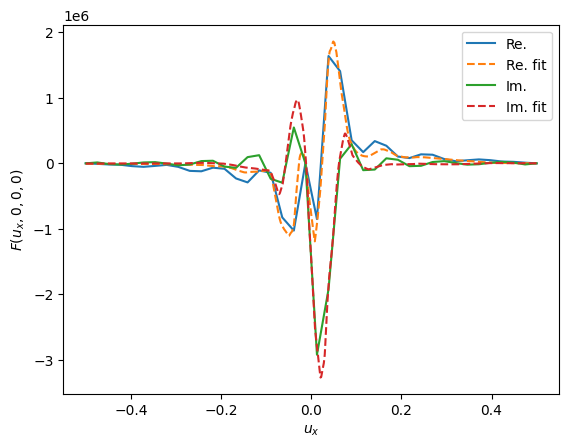

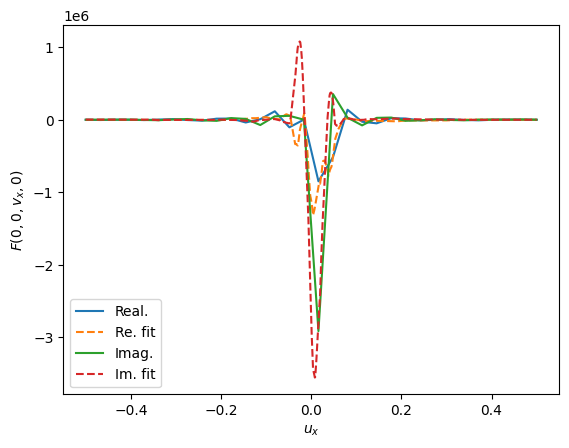

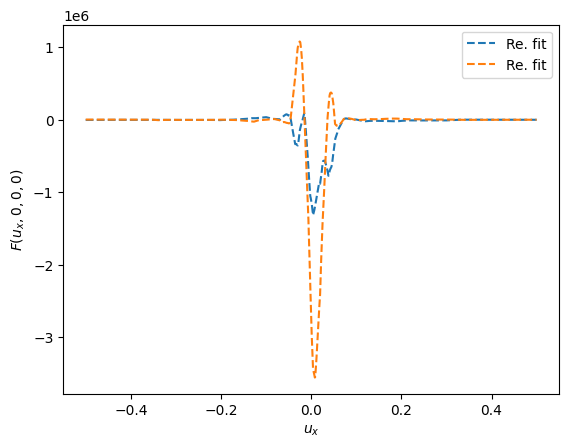

In [7]:
##PLOT TEST to FIT
U1_new = np.linspace(-sis.L/2, sis.L/2, 2048)
fit_test_re_u1 = .0 * U1_new 
fit_test_im_u1 = .0 * U1_new 

fit_test_re_v1 = .0 * U1_new 
fit_test_im_v1 = .0 * U1_new 

for l in range(len(U1_new)):
    fit_test_re_u1[l] = fit(torch.tensor([U1_new[l], sis.U2[sis.Nu2//2], sis.V1[sis.Nv1//2], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[0]

    fit_test_im_u1[l] = fit(torch.tensor([U1_new[l], sis.U2[sis.Nu2//2], sis.V1[sis.Nv1//2], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[1]

    fit_test_re_v1[l] = fit(torch.tensor([sis.U1[sis.Nu1//2], sis.U2[sis.Nu2//2], U1_new[l], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[0]

    fit_test_im_v1[l] = fit(torch.tensor([sis.U1[sis.Nu1//2], sis.U2[sis.Nu2//2], U1_new[l], sis.V2[sis.Nv2//2]], dtype = torch.float32).to(device)).cpu().detach()[1]



plt.plot(sis.U1, np.real(sis.Fsol[1, :, sis.Nu2//2, sis.Nv1//2, sis.Nv2//2]), label = "Re.")
plt.plot(U1_new, fit_test_re_u1, "--", label = "Re. fit")
plt.plot(sis.U1, np.imag(sis.Fsol[1, :, sis.Nu2//2, sis.Nv1//2, sis.Nv2//2]), label = "Im.")
plt.plot(U1_new, fit_test_im_u1, "--", label = "Im. fit")
plt.xlabel("$u_x$")
plt.ylabel("$F(u_x, 0, 0, 0)$")
plt.legend()
plt.show()

plt.plot(sis.V1, np.real(sis.Fsol[1,  sis.Nu1//2,  sis.Nu2//2, :, sis.Nv2//2 ]), label = "Real.")
plt.plot(U1_new, fit_test_re_v1, "--", label = "Re. fit")
plt.plot(sis.V1, np.imag(sis.Fsol[1, sis.Nu1//2,  sis.Nu2//2, :,  sis.Nv2//2 ]), label = "Imag.")
plt.plot(U1_new, fit_test_im_v1, "--", label = "Im. fit")
plt.xlabel("$u_x$")
plt.ylabel("$F(0, 0, v_x, 0)$")
plt.legend()
plt.show()


plt.plot(U1_new, fit_test_re_v1, "--", label = "Re. fit")
plt.plot(U1_new, fit_test_im_v1, "--", label = "Re. fit")

plt.xlabel("$u_x$")
plt.ylabel("$F(u_x, 0, 0, 0)$")
plt.legend()
plt.show()
#####

#def f_recon(xdom):
#    return (fit_re(xdom) + 1j * fit_im(xdom)

In [9]:
torch.save(fit, "saved_fits/new_fit_11.pth")

/home/marco/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/marco/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


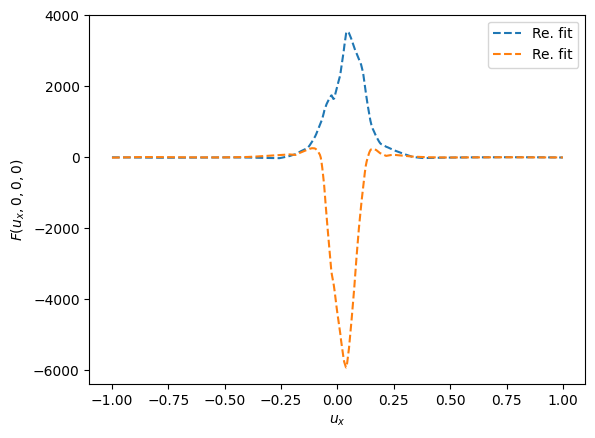

In [ ]:


plt.plot(U1_new, fit_test_re_u1 * np.real(np.exp(1j * sis.beta(sis.t) * U1_new**2)), "--", label = "Re. fit")
plt.plot(U1_new, fit_test_im_u1 * np.exp(1j * sis.beta(sis.t) * U1_new**2), "--", label = "Re. fit")

plt.xlabel("$u_x$")
plt.ylabel("$F(u_x, 0, 0, 0)$")
plt.legend()
plt.show()

In [7]:
torch.clear_autocast_cache()